In [30]:
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import open3d as o3d
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.ndimage import gaussian_filter1d
import time
import moviepy.video.io.ImageSequenceClip
import copy
import networkx as nx
import math
sys.path.insert(0,'/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')

from Signal_processing_utils import dx_dt, get_activity_interval, bilateral_filter_smoothing
from Interpolation_Util import CubicSplineInterpolation, CatmullRomSplineInterpolation
from sklearn.linear_model import Ridge
from utils import *


In [31]:
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport Signal_processing_utils
%aimport Interpolation_Util
# %matplotlib widget
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# input block
motion_data_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_jul4/MySlate_17_iPhone_cal.csv"
calibration_data_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_jul4/MySlate_17_iPhone_cal.csv"

# motion_data_path = "C:/Users/evan1/Documents/staggered_face/data/live_link_data/LiveLinkFace_20220926_MySlate_7_Evans_Iphone/MySlate_7_Evans_Iphone.csv"
mesh_to_name_path = "/Users/evanpan/Documents/GitHub/staggered_face/models/joonho_mesh_number_to_AU_name.json"
name_to_mesh_path = "/Users/evanpan/Documents/GitHub/staggered_face/models/joonho_AU_name_to_mesh_number.json"
out_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_jul4/for_maya_json.json"
model_path = "/Users/evanpan/Documents/GitHub/staggered_face/data/Apple blendshapes51 OBJs/OBJs"
mode = "acceleration"

# Custom Blendshape and visualization functions

## Visualize Keyposes (slide face)

In [33]:
# input
time_to_distance = 0.2
speed = 1 # 
def visualize_key_poses(animation:BlendshapeAnimation, key_times:np.array, save_video=False, video_path = "./video.mp4"):
    # introduce call back functions to stop the animation
    start_t = time.time()
    t = 0
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Face_visualize', width=1800, height=600)
    vis.get_render_option().mesh_show_wireframe = True
    poses = []
    for i in range(0, len(key_times)):
        pose: o3d.geometry = copy.deepcopy(animation.eval(key_times[i]))
        # print(time_to_distance * key_times[i])
        pose = pose.translate([time_to_distance * (key_times[i]) / speed , 0, 0])
        pose = pose.paint_uniform_color([0.95, 0.95, 0.95])
        vis.add_geometry(pose, reset_bounding_box=False)
        poses.append(pose)
    vis.add_geometry(animation.eval(0))
    # do the while loop and translate each object
    animation.translate(np.array([0, 0, 0.03]))
    frames = []
    while t < animation.ts[-1]:
        if not save_video:
            dt = (time.time() - start_t - t)
        else:
            dt = 1.0/30.0
        t += dt
        vis.get_view_control().camera_local_translate(0, dt*time_to_distance, 0)
        animation.translate(np.array([dt*time_to_distance, 0, 0]))
        vis.update_geometry(animation.eval(t))
        event = vis.poll_events()
        vis.update_renderer()
        # capture the image if we are saving the video
        if save_video:
            im = vis.capture_screen_float_buffer(True)
            frames.append((np.asarray(im)))
    vis.destroy_window()
    if save_video:
        # if this does work, pip install upgrade "moviepy" lol
        # Define the video writer
        uint8_frames = [(f*255).astype(np.uint8) for f in frames]
        clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(uint8_frames, fps=30)
        clip.write_videofile(video_path)
    return frames

## Visualize Keyposes (slide face with zoom and pauses)

In [7]:
time_to_distance_close = 0.1
time_to_distance_far = 0.01
loc_on_screen = np.array((0.15, 0, 0))
def zooming_visualize_key_poses(animation:BlendshapeAnimation, key_times:np.array, save_video=False, video_path = "./video.mp4", pause_length = 0.2):
    def transform_mesh(mesh: o3d.geometry, delta_pos:np.array):
        mesh.vertices = o3d.utility.Vector3dVector(np.asarray(mesh.vertices) + np.expand_dims(delta_pos, axis=0))
        return mesh
    # introduce call back functions to stop the animation
    start_t = time.time()
    t = 0
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Face_visualize', width=1800, height=600)
    vis.get_render_option().mesh_show_wireframe = True
    # vis.rendering.Camera.Projection = 1
    vis.add_geometry(animation.eval(0))
    animation.translate(loc_on_screen)
    poses = []
    for i in range(0, len(key_times)):
        animation.eval(key_times[i])
        pose: BasicBlendshapeModel = copy.deepcopy(animation.model)
        # print(time_to_distance * key_times[i])
        pose.translate(np.array([time_to_distance_close * (key_times[i]), 0, 0]))
        pose.visualization_mesh.paint_uniform_color([0.95, 0.95, 0.95])
        vis.add_geometry(pose.eval(), reset_bounding_box=False)
        poses.append(pose)
    
    # do the while loop and translate each object
    animation.translate(np.array([0, 0, 0.03]))
    frames = []
    lag_time = 0
    while t < animation.ts[-1]:
        vis.get_view_control().change_field_of_view(-90)
        if not save_video:
            dt = (time.time() - start_t - t)
        else:
            dt = 1.0/30.0
        # the lag will get reduced first before anything else happens
        lag_time -= dt
        lag_time = max(0, lag_time)
        if lag_time <= 0:
            t += dt
            # vis.get_view_control().camera_local_translate(0, dt*time_to_distance, 0)
            # animation.translate(np.array([dt*time_to_distance, 0, 0]))
            min_delta_t = 100
            for i in range(0, len(poses)):
                delta_t = np.abs(t - key_times[i])
                poses[i].translate([-time_to_distance_close * dt , 0, 0])
                scaling = max(1 - delta_t, 0.07)
                poses[i].scale(scaling)
                vis.update_geometry(poses[i].eval())
                min_delta_t = min(delta_t, min_delta_t)
            vis.update_geometry(animation.eval(t))
            event = vis.poll_events()
            vis.update_renderer()
            if min_delta_t <= dt / 2:
                lag_time += pause_length
                start_t += pause_length
        # capture the image if we are saving the video
        if save_video:
            im = vis.capture_screen_float_buffer(True)
            frames.append((np.asarray(im)))
    vis.destroy_window()
    if save_video:
        # if this does work, pip install upgrade "moviepy" lol
        # Define the video writer
        uint8_frames = [(f*255).astype(np.uint8) for f in frames]
        clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(uint8_frames, fps=30)
        clip.write_videofile(video_path)
    return frames

# Gather input

## Obtain the predicted blendshapes

In [29]:
times, values_dict = load_apple_motion(motion_data_path, 30, calibration_data_path)
all_AU = []
labels = list(values_dict.keys())
for i in range(0, len(labels)):
    all_AU.append(labels[i])
model = BasicBlendshapeModel()
model = load_blendshape_model(model_path, model)
animation = BlendshapeAnimation(model, calibration_data_path)
# play_animation(animation, save_video=True)


# Geometry based extreme poses

In [10]:
ARkit_2_blendshapeModel_map = {'eyeblink_r': 'eyeblinkright', 'eyelookdown_r': 'eyelookdownright', 'eyelookin_r': 'eyelookinright', 'eyelookout_r': 'eyelookoutright', 'eyelookup_r': 'eyelookupright', 'eyesquint_r': 'eyesquintright', 'eyewide_r': 'eyewideright', 'eyeblink_l': 'eyeblinkleft', 'eyelookdown_l': 'eyelookdownleft', 'eyelookin_l': 'eyelookinleft', 'eyelookout_l': 'eyelookoutleft', 'eyelookup_l': 'eyelookupleft', 'eyesquint_l': 'eyesquintleft', 'eyewide_l': 'eyewideleft', 'jawforward': 'jawforward', 'jawright': 'jawright', 'jawleft': 'jawleft', 'jawopen': 'jawopen', 'mouthclose': 'mouthclose', 'mouthfunnel': 'mouthfunnel', 'mouthpucker': 'mouthpucker', 'mouthright': 'mouthright', 'mouthleft': 'mouthleft', 'mouthsmile_r': 'mouthsmileright', 'mouthsmile_l': 'mouthsmileleft', 'mouthfrown_r': 'mouthfrownright', 'mouthfrown_l': 'mouthfrownleft', 'mouthdimple_r': 'mouthdimpleright', 'mouthdimple_l': 'mouthdimpleleft', 'mouthstretch_r': 'mouthstretchright', 'mouthstretch_l': 'mouthstretchleft', 'mouthrolllower': 'mouthrolllower', 'mouthrollupper': 'mouthrollupper', 'mouthshruglower': 'mouthshruglower', 'mouthshrugupper': 'mouthshrugupper', 'mouthpress_r': 'mouthpressright', 'mouthpress_l': 'mouthpressleft', 'mouthlowerdown_r': 'mouthlowerdownright', 'mouthlowerdown_l': 'mouthlowerdownleft', 'mouthupperup_r': 'mouthupperupright', 'mouthupperup_l': 'mouthupperupleft', 'browdown_r': 'browdownright', 'browdown_l': 'browdownleft', 'browinnerup': 'browinnerup', 'browouterup_r': 'browouterupright', 'browouterup_l': 'browouterupleft', 'cheekpuff': 'cheekpuff', 'cheeksquint_r': 'cheeksquintright', 'cheeksquint_l': 'cheeksquintleft', 'nosesneer_r': 'nosesneerright', 'nosesneer_l': 'nosesneerleft'}

## MSE based Extreme Pose (find peaks in the MSE error graph)

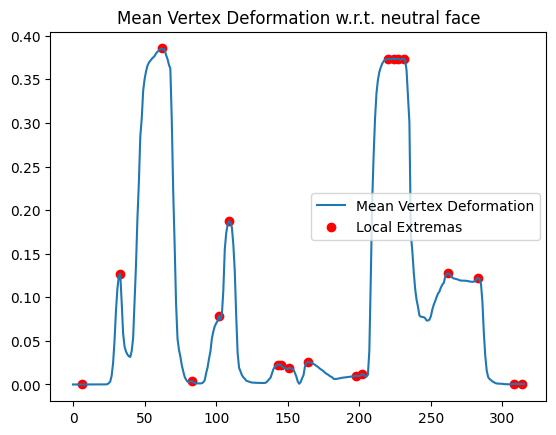

In [15]:
from scipy.signal import argrelextrema
ts = animation.ts
mse_diff = []
for t in ts:
    face_i = animation.eval(t)
    face_neutral = animation.model.neutral_mesh
    face_i = np.asarray(face_i.vertices)
    face_neutral = np.asarray(face_neutral.vertices)
    mse_diff.append(np.sum(np.square(face_i - face_neutral), axis=1).sum())
mse_diff = np.array(mse_diff)
extremes = argrelextrema(mse_diff, np.greater)[0]

extremes_filtered = extremes
plt.clf()
plt.title("Mean Vertex Deformation w.r.t. neutral face")
plt.plot(mse_diff, label="Mean Vertex Deformation")
plt.scatter(extremes_filtered, mse_diff[extremes_filtered], c="r", label="Local Extremas")
plt.legend()
plt.show()

face = BasicBlendshapeModel()
face = load_blendshape_model(model_path, face)
animation = BlendshapeAnimation(face, motion_data_path)

# zooming_visualize_key_poses(animation, animation.ts[extremes_filtered], pause_length=0)


# Per AU Local information Based Extreme Poses

EyeLookOutLeft


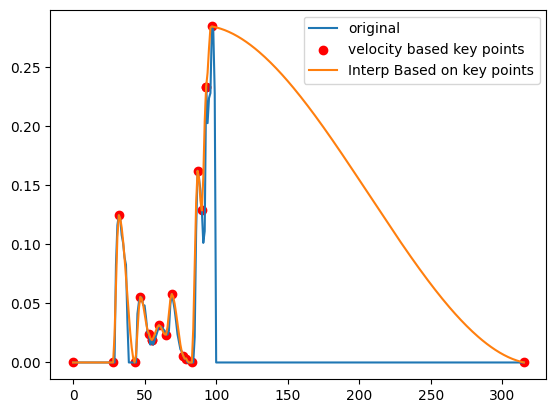

In [11]:
vel_threshold = 0.005
noise_threshold = 0.1
plt.clf()
curve_index = 3
vel_curve_dict = {}
for i in range(curve_index, len(all_AU)):
    au_i = all_AU[i]
    au_i_curve = values_dict[au_i]
    filtered_au_i_curve = au_i_curve
    plt.plot(filtered_au_i_curve, label="original")
    # find onset
    au_i_vel_curve_forward = dx_dt(filtered_au_i_curve, dt=1/30.0, method=1)
    au_i_vel_curve_backward = dx_dt(filtered_au_i_curve, dt=1/30.0, method=3)
    key_points = np.zeros(au_i_vel_curve_forward.shape)
    ts = list(range(0, au_i_vel_curve_forward.shape[0]))
    for t in ts:
        # if the AU is increasing sufficiently we set the element in the onsets array it to 1
        # here we use backward differences to capture the onset t[i+1] - t[i]
        if au_i_vel_curve_backward[t] <= vel_threshold:
            key_points[t] = 1

    filtered_vel_key_point = get_activity_interval(key_points, np.array(ts))
    
    vel_key_frame = [x[0] for x in filtered_vel_key_point]
    vel_key_frame += [x[1] for x in filtered_vel_key_point]
    vel_key_frame = sorted(vel_key_frame)
    vel_curve_dict[au_i] = vel_key_frame
    # activation, peak, sustain and deactivation values
    plt.scatter(vel_key_frame, filtered_au_i_curve[vel_key_frame], c="r", label="velocity based key points")
    approximation = CatmullRomSplineInterpolation(np.array(ts)[vel_key_frame], filtered_au_i_curve[vel_key_frame], tao=0.2)
    plt.plot(np.maximum(0, approximation.eval(np.array(ts))), label="Interp Based on key points")
    # approximation = CubicSplineInterpolation(np.array(ts)[all_key_frames], filtered_au_i_curve[all_key_frames])
    # plt.plot(np.maximum(0, approximation.eval(np.array(ts))), label="culic spline")
    if i == curve_index:
        break
print(au_i)
plt.legend()

# Onset based extreme poses

## find motion onsets, offsets, peaks and sustains (per blendweight)

NoseSneerRight


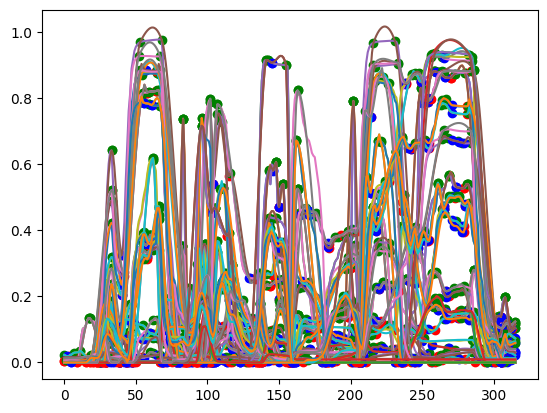

In [12]:
onset_threshold = 0.05
offset_threshold = 0.05
noise_threshold = 0.2
plt.clf()
curve_index = 0
onset_curve_dict = {}
offset_curve_dict = {}
labeled_key_frame_dict = {}
for i in range(curve_index, len(all_AU)):
    au_i = all_AU[i]
    au_i_curve = values_dict[au_i]
    filtered_au_i_curve = au_i_curve
    plt.plot(filtered_au_i_curve, label="original")
    # find onset
    au_i_vel_curve_forward = dx_dt(filtered_au_i_curve, dt=1/30.0, method=1)
    au_i_vel_curve_backward = dx_dt(filtered_au_i_curve, dt=1/30.0, method=3)
    onsets = np.zeros(au_i_vel_curve_forward.shape)
    offsets = np.zeros(au_i_vel_curve_forward.shape)
    ts = list(range(0, au_i_vel_curve_forward.shape[0]))
    for t in ts:
        # if the AU is increasing sufficiently we set the element in the onsets array it to 1
        # here we use backward differences to capture the onset t[i+1] - t[i]
        if au_i_vel_curve_backward[t] >= onset_threshold or au_i_vel_curve_forward[t] >= onset_threshold: 
            onsets[t] = 1
        # if the AU is decreasing sufficiently we set the element in the offsets array it to 1
        # here we use backward difference 
        if au_i_vel_curve_forward[t] <= -offset_threshold or au_i_vel_curve_backward[t] <= -offset_threshold:
            offsets[t] = 1
    # merge nearby active labels into intervals. (i.e. if there is a group of 1s they are now clustered)
    action_unit_onset_activity = get_activity_interval(onsets, np.array(ts))
    action_unit_offset_activity = get_activity_interval(offsets, np.array(ts))
    onset_curve_dict[au_i] = onsets
    offset_curve_dict[au_i] = offsets
    # activation, peak, sustain and deactivation values
    activation = [x[0] for x in action_unit_onset_activity]
    peak = [x[1] for x in action_unit_onset_activity]
    sustain = [x[0] for x in action_unit_offset_activity]
    deactivation = [x[1] for x in action_unit_offset_activity]
    # plot all the key points
    labeled_key_frames = []
    plt.scatter(activation, filtered_au_i_curve[activation], c="r", label="motion onset")
    plt.scatter(peak, filtered_au_i_curve[peak], c="g", label="motion peak")
    plt.scatter(sustain, filtered_au_i_curve[sustain], c="g", label="motion sustain")
    plt.scatter(deactivation, filtered_au_i_curve[deactivation], c="b", label="motion end")
    for pts in activation:
        labeled_key_frames.append([pts, "a"])
    for pts in peak:
        labeled_key_frames.append([pts, "p"])
    for pts in sustain:
        labeled_key_frames.append([pts, "s"])
    for pts in deactivation:
        labeled_key_frames.append([pts, "d"])
    # sort all the potential key frames by time
    if len(labeled_key_frames) == 0:
        labeled_key_frames = [[0, "a"], [len(ts)-1, "d"]]
    labeled_key_frames = sorted(labeled_key_frames, key=lambda x: x[0])
    filtered_labeled_kay_frames = []
    ff = 0
    while ff < len(labeled_key_frames) - 1:
        current = labeled_key_frames[ff]
        next = labeled_key_frames[ff+1]
        if current[0] != next[0]:
            filtered_labeled_kay_frames.append(current)
        # elif (current[1] == "a" and next[1] == "p") or (current[1] == "s" and next[1] == "d"):
        elif (current[1] == "a" and next[1] == "d") or (current[1] == "d" and next[1] == "a"):
            filtered_labeled_kay_frames.append([current[0], "d"])
            filtered_labeled_kay_frames.append([current[0], "a"])
            ff += 1
        elif au_i_curve[current[0]] <= noise_threshold:
            filtered_labeled_kay_frames.append([current[0], "z"])
            filtered_labeled_kay_frames.append([current[0], "z"])
            ff += 1
        ff += 1
    # add the last frame (which is probably missing )
    filtered_labeled_kay_frames.append(labeled_key_frames[-1])
    # replace the keyframed with the filtered version
    labeled_key_frames = copy.deepcopy(filtered_labeled_kay_frames)
    # save the keyframe
    labeled_key_frame_dict[au_i] = labeled_key_frames
    plotting_key_frames = [x[0] for x in labeled_key_frames]
    approximation = CatmullRomSplineInterpolation(np.array(ts)[plotting_key_frames], filtered_au_i_curve[plotting_key_frames], tao=0.2)
    plt.plot(np.maximum(0, approximation.eval(np.array(ts))), label="catmull rom")
    # approximation = CubicSplineInterpolation(np.array(ts)[all_key_frames], filtered_au_i_curve[all_key_frames])
    # plt.plot(np.maximum(0, approximation.eval(np.array(ts))), label="culic spline")
    # if i == curve_index:
    #     break
    # plt.show()
print(au_i)
# plt.legend()

## Abstract motion using sharkfin curves

In [13]:
class SharkFinCurve():
    def __init__(self, all_frames, all_key_frames, ts, curve):
        # all_frames: are all the keyframes in the sharkfin carve
        # curve: is the data that the keyframe points to
        self.all_frame_ids = all_frames.copy()  # this index into keyframes
        self.key_frame_ids = []                 # this index into keyframes
        self.key_frames = all_key_frames        # this index into curve
        self.ts = ts
        self.curve = copy.deepcopy(curve)       # this is the value
        self.fit_sharkfin()
    def get_min_key_frames(self):
        min_key_frames = [self.key_frames[j][0] for j in self.key_frame_ids]
        return min_key_frames
    def get_x(self, kfid):
        return self.key_frames[kfid][0]
    def get_y(self, kfid):
        return self.curve[self.key_frames[kfid][0]]
    def get_peak(self):
        kf0 = self.get_x(self.all_frame_ids[0])
        kf1 = self.get_x(self.all_frame_ids[1])
        peak_x = np.argmax(self.curve[kf0:kf1]) + kf0
        peak_y = self.curve[peak_x]
        return peak_x, peak_y
    def get_range(self):
        kf0 = self.get_x(self.all_frame_ids[0])
        kf1 = self.get_x(self.all_frame_ids[1])
        return [self.ts[kf0], self.ts[kf1]]
    def get_all_key_frames(self):
        all_key_frames = [self.key_frames[j][0] for j in self.all_frame_ids]
        return all_key_frames
    def fit_sharkfin_heuristic(self):
        self.key_frame_ids = [self.all_frame_ids[0], 0, 0, self.all_frame_ids[-1]]
        # define the peak key frame as the one with the maximum ascent
        max_ascend = -1
        max_ascend_id = -1
        for i in range(0, len(self.all_frame_ids)-1):
            ascend = (self.curve[self.key_frames[self.all_frame_ids[i]][0]] - self.curve[self.key_frames[self.all_frame_ids[0]][0]]
                     )/(self.key_frames[self.all_frame_ids[i]][0] - self.key_frames[self.all_frame_ids[0]][0])
            if ascend > max_ascend:
                max_ascend_id = self.all_frame_ids[i]
        max_descend = 1
        max_descend_id = -1
        # define the sustain key frame as the one with the maximum descent ()
        for i in range(0, len(self.all_frame_ids)-1):
            descend = (self.curve[self.key_frames[self.all_frame_ids[-1]][0]] - self.curve[self.key_frames[self.all_frame_ids[i]][0]]
                     )/(self.key_frames[self.all_frame_ids[-1]][0] - self.key_frames[self.all_frame_ids[i]][0])
            if descend < max_descend:
                max_descend_id = self.all_frame_ids[i]
        self.key_frame_ids[1] = max_ascend_id
        self.key_frame_ids[2] = max_descend_id
        # print(self.key_frame_ids)
    def fit_sharkfin_least_square(self):
        # does not work with catmull rom because the parameterization is dependent on the 2 central points, which we are trying to find
        self.key_frame_ids = [self.all_frame_ids[0], 0, 0, self.all_frame_ids[-1]]
        tao = 0.2
        tension_mat = np.array([[0, 1, 0, 0], 
                    [-tao, 0, tao, 0], 
                    [2 * tao, tao - 3, 3 - 2 * tao, -tao],
                    [-tao, 2 - tao, tao - 2, tao]])
        xs = np.arange(self.key_frames[self.key_frame_ids[0]][0], self.key_frames[self.key_frame_ids[-1]][0]+1)
        ys = self.curve[self.key_frames[self.key_frame_ids[0]][0]:self.key_frames[self.key_frame_ids[-1]][0]+1]
        X_mat = np.array([np.ones(xs.shape), xs, np.square(xs), np.power(xs, 3)]).T
        print(xs, ys)
        ys = np.expand_dims(ys, axis=1) - self.key_frames[self.key_frame_ids[0]][0] * X_mat @ tension_mat[:, 0:1] - self.key_frames[self.key_frame_ids[-1]][0] * X_mat @ tension_mat[:, 3:4]
        # solve Ax = b where A = X_mat[1:3], x = [p1, p2], b = y
        A_mat = X_mat[:, 1:3]
        p_solv = np.linalg.inv(A_mat.T @ A_mat) @ A_mat.T @ ys
        # now try to find keyframe that most closely resemble these)
        # for i in range(0, len(self.key_frame_ids)):
    def fit_sharkfin_best_hull(self):
        # try to find the best hull greedily 
        def find_above(points_x, points_y, x, y):
            # this function fins how might higher the line constructed with points_x_y is compare to x,y
            if x >= points_x[1] and points_x[1] != points_x[2]:
                x0 = points_x[1]
                x1 = points_x[2]
                y0 = points_y[1]
                y1 = points_y[2]
            elif x < points_x[1] and points_x[1] != points_x[0]:
                x0 = points_x[0]
                x1 = points_x[1]
                y0 = points_y[0]
                y1 = points_y[1]
            else:
                return 0
            
            val = (x - x0) / (x1 - x0) * (y1 - y0) + y0
            return val - y
        def search_sub_list(start, end):
            st = start   
            ed = end
            distances = []
            for i in range(st, ed+1):
                # construct a hull using the 2 starting point and a point in the middle. 
                total_above_ness = 0
                for j in range(st, ed+1):
                    total_above_ness += find_above([self.get_x(self.all_frame_ids[st]), self.get_x(self.all_frame_ids[i]), self.get_x(self.all_frame_ids[ed])], 
                                                [self.get_y(self.all_frame_ids[st]), self.get_y(self.all_frame_ids[i]), self.get_y(self.all_frame_ids[ed])], 
                                                self.get_x(self.all_frame_ids[j]), self.get_y(self.all_frame_ids[j]))
                distances.append(total_above_ness)
            return np.argmax(distances) + start
        # print(distances)
        self.key_frame_ids = [self.all_frame_ids[0], 0, 0, self.all_frame_ids[-1]]
        if len(self.all_frame_ids) <= 4: 
            self.key_frame_ids = self.all_frame_ids.copy()
            return
        # find a starting point for search
        distances = 0
        distances = [-1000]
        st = 0
        ed = len(self.all_frame_ids)-1
        for i in range(st+1, ed):
            # construct a hull using the 2 starting point and a point in the middle. 
            total_above_ness = 0
            for j in range(st+1, ed):
                total_above_ness += find_above([self.get_x(self.all_frame_ids[st]), self.get_x(self.all_frame_ids[i]), self.get_x(self.all_frame_ids[ed])], 
                                               [self.get_y(self.all_frame_ids[st]), self.get_y(self.all_frame_ids[i]), self.get_y(self.all_frame_ids[ed])], 
                                               self.get_x(self.all_frame_ids[j]), self.get_y(self.all_frame_ids[j]))
            distances.append(total_above_ness)
        distances.append(-1000)
        # seek the left and right side of the starting point to find more points
        p_mid = np.argmax(distances)
        p1 = -1
        p2 = -1
        if p_mid > st:
            p1 = search_sub_list(st, p_mid)
        else:
            p1 = p_mid
        if p_mid < ed - 1:
            p2 = search_sub_list(p_mid, ed)
        else:
            p2 = p_mid
            
        self.key_frame_ids[1] = self.all_frame_ids[p1]
        self.key_frame_ids[2] = self.all_frame_ids[p2]
    def fit_sharkfin(self):
        self.fit_sharkfin_best_hull()        

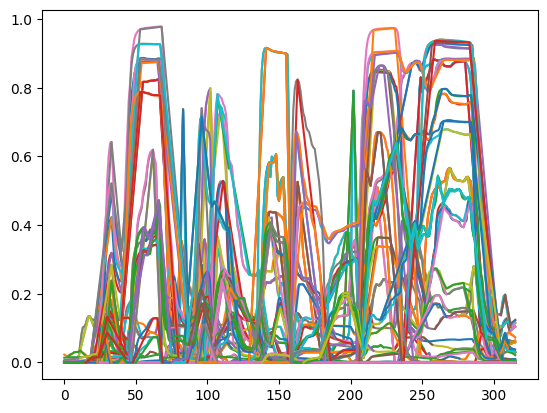

In [14]:
# input: 
noise_threshold
# Keyframe curves
labeled_key_frame_dict
# original values
values_dict
# time array
times
# output: 
sharkfin_curves_dict = {}
for au_i in labeled_key_frame_dict:
# if True:
#     au_i = "EyeLookInLeft"
    # input curves
    key_frames = labeled_key_frame_dict[au_i]
    values = values_dict[au_i]
    # output curves
    sharkfin_curve_list:list[SharkFinCurve] = []
    plt.plot(values)
    start = False
    current_interval = []
    all_intervals = []
    for i in range(0, len(key_frames)):
        if (key_frames[i][1] == "a") and len(current_interval) == 0 and start == False:
            start = True
            current_interval.append(i) # index to key-frames
        # I only add to the list of sharkfin curves if the current motion ended (i.e. descent to a value < 0.05)
        elif (key_frames[i][1] == "d") and values[key_frames[i][0]] <= noise_threshold and start == True:
            start = False
            current_interval.append(i)
            # save the curve if it's significant enough
            # if np.max(current_interval) >= noise_threshold:
            sharkfin_curve_list.append(SharkFinCurve(current_interval, key_frames, times, values))
            all_intervals.append(current_interval.copy())
            current_interval = []
        elif i == len(key_frames) - 1 and start == True:
            current_interval.append(i)
            # save the curve if it's significant enough
            sharkfin_curve_list.append(SharkFinCurve(current_interval, key_frames, times, values))
            all_intervals.append(current_interval.copy())
            current_interval = []
        elif start == True:
            current_interval.append(i)
    sharkfin_curves_dict[au_i] = copy.deepcopy(sharkfin_curve_list)
    tsss = np.arange(0, values.shape[0])
    for j in range(0, len(sharkfin_curve_list)):
        ts = sharkfin_curve_list[j].get_min_key_frames()
        ts = [sharkfin_curve_list[j].key_frames[m][0] for m in sharkfin_curve_list[j].all_frame_ids]
        catmul = CatmullRomSplineInterpolation(np.array(ts), np.array(values)[ts], tao = 0.2)
        plt.plot(np.array(ts), catmul.eval(np.array(ts)))
        # plt.plot(np.array(ts), values[ts])
    # plt.show()

## Visualize the keyframe approximation

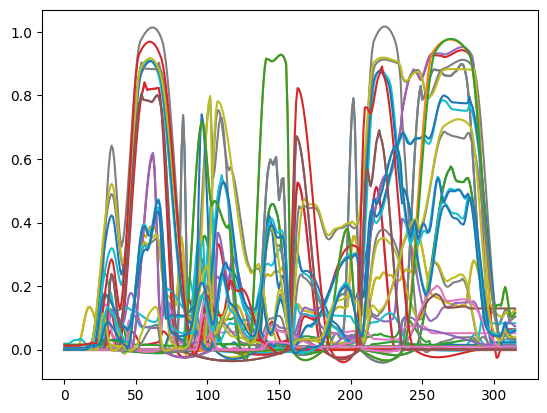

In [15]:
# interpolate using the sharkfin approximation of the motion curves (this can probably be an envelope)
sharkfin_fullcurve_dict = {}
for key in sharkfin_curves_dict:
    # list of sharkfin curve objects
    raw_curve = values_dict[key]
    sharkfin_curve_list = sharkfin_curves_dict[key]
    
    sharkfin_key_frames_frames = []
    for i in range(0, len(sharkfin_curve_list)):
        sharkfin_key_frames_frames += sharkfin_curve_list[i].get_all_key_frames()
    sharkfin_key_frames_ys = raw_curve[sharkfin_key_frames_frames]
    sharkfin_key_frames_ts = np.array(times)[sharkfin_key_frames_frames]
    catmul = CatmullRomSplineInterpolation(np.array(sharkfin_key_frames_ts), np.array(raw_curve)[sharkfin_key_frames_frames], tao = 0.2)
    sharkfin_fullcurve_dict[key] = catmul.eval(np.array(times))
    plt.plot(sharkfin_fullcurve_dict[key])

In [16]:
animation = BlendshapeAnimation(model, ts=np.array(times), values_dict=sharkfin_fullcurve_dict)
# play_animation(animation, save_video=True, video_path="approximation.mp4")

## Visualize the control envelope

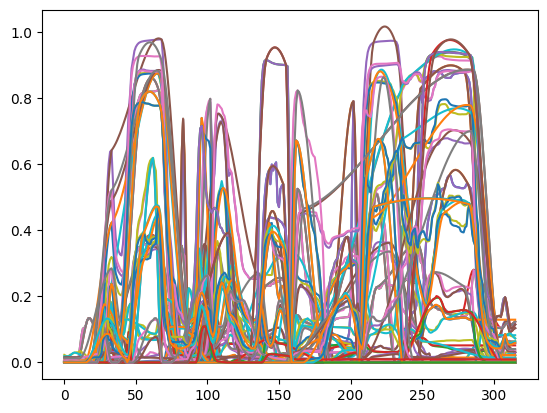

In [17]:
# interpolate using the sharkfin approximation of the motion curves (this can probably be an envelope)
sharkfin_fullcurve_dict = {}
for key in sharkfin_curves_dict:
    # list of sharkfin curve objects
    raw_curve = values_dict[key]
    sharkfin_curve_list = sharkfin_curves_dict[key]
    
    sharkfin_key_frames_frames = []
    for i in range(0, len(sharkfin_curve_list)):
        sharkfin_key_frames_frames += sharkfin_curve_list[i].get_min_key_frames()
    sharkfin_key_frames_ys = raw_curve[sharkfin_key_frames_frames]
    sharkfin_key_frames_ts = np.array(times)[sharkfin_key_frames_frames]
    catmul = CatmullRomSplineInterpolation(np.array(sharkfin_key_frames_ts), np.array(raw_curve)[sharkfin_key_frames_frames], tao = 0.2)
    sharkfin_fullcurve_dict[key] = catmul.eval(np.array(times)) 
    plt.plot(np.maximum(0, raw_curve))
    plt.plot(np.maximum(0, sharkfin_fullcurve_dict[key]))
    # plt.show()

In [18]:
animation = BlendshapeAnimation(model, ts=np.array(times), values_dict=sharkfin_fullcurve_dict)
# play_animation(animation, save_video=True, video_path="bad_appeox.mp4")

In [19]:
rough_animation = BlendshapeAnimation(model, ts=np.array(times), values_dict=sharkfin_fullcurve_dict)
# play_animation(rough_animation)

# Grouping Sharfin Curves

## Graph Based approach

In [22]:
key_width = 4

### Construct keyframe graph

In [23]:
# input
sharkfin_curves_dict # dictionary of sharkfin curve objects
values_dict # dictionary of the actual values of those curves
times
# outout
assignment = []

# get variable ready to do stuff
keyframe_graph = nx.Graph()  # create graph object
node_names = []        # a list of node names
nodes2sharkfin_id = {}  # got from the id 

# assemble the nodes of the graph
for key in sharkfin_curves_dict:
    for i in range(0, len(sharkfin_curves_dict[key])):
        node_name = "_".join([key, str(i)])
        nodes2sharkfin_id[len(node_names)] = [key, i]
        node_names.append(node_name)
keyframe_graph.add_nodes_from(node_names)

# draw edge between nodes if they overlap
for i in range(0, len(node_names)):
    for j in range(0, len(node_names)):
        # get the action unit i and j
        au_i, id_i = nodes2sharkfin_id[i]
        au_j, id_j = nodes2sharkfin_id[j]
        if au_i == au_j:
            continue
        shark_fin_i = sharkfin_curves_dict[au_i][id_i]
        shark_fin_j = sharkfin_curves_dict[au_j][id_j]
        if do_intersect(shark_fin_i, shark_fin_j, key_width):
            keyframe_graph.add_edge(node_names[i], node_names[j])
# nx.draw(keyframe_graph)
# plt.show()

### Solve for connected components

In [24]:
groups = list(nx.connected_components(keyframe_graph))

In [25]:
groups

[{'BrowDownLeft_0',
  'BrowDownLeft_1',
  'BrowDownRight_0',
  'BrowDownRight_1',
  'BrowInnerUp_2',
  'BrowInnerUp_3',
  'BrowInnerUp_4',
  'BrowInnerUp_5',
  'BrowOuterUpLeft_2',
  'BrowOuterUpRight_2',
  'CheekPuff_0',
  'CheekPuff_1',
  'CheekSquintLeft_3',
  'CheekSquintLeft_4',
  'CheekSquintLeft_5',
  'CheekSquintLeft_6',
  'CheekSquintRight_3',
  'CheekSquintRight_4',
  'CheekSquintRight_5',
  'CheekSquintRight_6',
  'EyeBlinkLeft_0',
  'EyeBlinkLeft_1',
  'EyeBlinkRight_0',
  'EyeBlinkRight_1',
  'EyeLookDownLeft_3',
  'EyeLookDownLeft_4',
  'EyeLookDownLeft_5',
  'EyeLookDownLeft_6',
  'EyeLookDownLeft_7',
  'EyeLookDownRight_3',
  'EyeLookDownRight_4',
  'EyeLookDownRight_5',
  'EyeLookDownRight_6',
  'EyeLookDownRight_7',
  'EyeLookInLeft_1',
  'EyeLookInLeft_2',
  'EyeLookInLeft_3',
  'EyeLookInLeft_4',
  'EyeLookInLeft_5',
  'EyeLookInLeft_6',
  'EyeLookInRight_4',
  'EyeLookInRight_5',
  'EyeLookInRight_6',
  'EyeLookOutLeft_2',
  'EyeLookOutLeft_3',
  'EyeLookOutLeft_4'

### Visualize SUPER poses

In [54]:
# input
time_to_distance_close = 0.2
speed = 1

def visualize_superpose(animation:BlendshapeAnimation, superposes:list[SuperFrame], values_dict, save_video=False, video_path = "./video.mp4", pause_length = 0.2):
    def transform_mesh(mesh: o3d.geometry, delta_pos:np.array):
        mesh.vertices = o3d.utility.Vector3dVector(np.asarray(mesh.vertices) + np.expand_dims(delta_pos, axis=0))
        return mesh
    maximum_displacement_vertices, maximum_displacement_indices, all_indices = maximum_k_displacement_vertex(animation.model, k=1)
    # introduce call back functions to stop the animation
    start_t = time.time()
    t = 0
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Face_visualize', width=1800, height=600)
    vis.get_render_option().mesh_show_wireframe = True
    # vis.rendering.Camera.Projection = 1
    animation.translate(loc_on_screen)
    vis.add_geometry(animation.eval(0))
    poses = []
    for i in range(0, len(superposes)):
        super_frame: SuperFrame = superposes[i]
        pose = copy.deepcopy(animation.model)
        pose = super_frame.set_super_frame(pose, values_dict)
        pose.translate(np.array([time_to_distance_close * (animation.ts[superposes[i].frame_center]), 0, 0]))
        pose.visualization_mesh.paint_uniform_color([0.95, 0.95, 0.95])
        # paint maximum displaced vertices with red
        vertex_colors = np.asarray(pose.visualization_mesh.vertex_colors)
        for dispalced_blendshape in super_frame.frame_off_sets:
            for v in maximum_displacement_indices[dispalced_blendshape.lower()]:
                vertex_colors[v] = np.array([1, 0, 0])
        pose.visualization_mesh.vertex_colors = o3d.utility.Vector3dVector(vertex_colors)
        # colors[0] = [0, 0,]
        # print(np.asarray(pose.visualization_mesh.vertex_colors))
        vis.add_geometry(pose.eval(), reset_bounding_box=False)
        # Give each activated vertex of interest a color:
        # A[2983298329]
        poses.append(pose)
    # do the while loop and translate each object
    animation.translate(np.array([0, 0, -0.03]))
    frames = [] 
    lag_time = 0
    while t < animation.ts[-1]:
        vis.get_view_control().change_field_of_view(-90)
        if not save_video:
            dt = (time.time() - start_t - t)
        else:
            dt = 1.0/30.0
        # the lag will get reduced first before anything else happens
        lag_time -= dt
        lag_time = max(0, lag_time)
        if lag_time <= 0:
            t += dt
            # vis.get_view_control().camera_local_translate(0, dt*time_to_distance, 0)
            # animation.translate(np.array([dt*time_to_distance, 0, 0]))
            min_delta_t = 100
            for i in range(0, len(poses)):
                # print(superposes[i].frame_center)
                delta_t = np.abs(t - animation.ts[superposes[i].frame_center])
                poses[i].translate([-time_to_distance_close * dt , 0, 0])
                scaling = max(1 - delta_t, 0.07)
                poses[i].scale(scaling)
                vis.update_geometry(poses[i].eval())
                min_delta_t = min(delta_t, min_delta_t)
            vis.update_geometry(animation.eval(t))
            event = vis.poll_events()
            vis.update_renderer()
            if min_delta_t <= dt / 2:
                lag_time += pause_length
                start_t += pause_length
        # during lag time, render spheres on the face
        else:
            pass

        # capture the image if we are saving the video
        if save_video:
            im = vis.capture_screen_float_buffer(True)
            frames.append((np.asarray(im)))
    vis.destroy_window()
    if save_video:
        # if this does work, pip install upgrade "moviepy" lol
        # Define the video writer
        uint8_frames = [(f*255).astype(np.uint8) for f in frames]
        clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(uint8_frames, fps=30)
        clip.write_videofile(video_path)
    return frames
# visualize_superpose(animation, super_frames, values_dict, True, "./super_frames.mp4", pause_length=0.5)

In [55]:
temp_model = copy.deepcopy(model)
super_frames = []
for i in range(0, len(groups)):
    group = groups[i]
    sharkfin_curves_in_group = []
    # get all the sharkfin_curves
    grouping = []
    for item in group:
        au_name, sharkfin_id = item.split("_")
        sharkfin_id = int(sharkfin_id)
        sharkfin: SharkFinCurve = sharkfin_curves_dict[au_name][sharkfin_id]
        peak = sharkfin.get_min_key_frames()[1]
        grouping.append([au_name, peak])
    super_frames.append(SuperFrame(grouping))
    super_frames[-1].set_super_frame(temp_model, values_dict)
frames = visualize_superpose(animation, super_frames, values_dict, True, "./super_frames.mp4", pause_length=0.5)

Moviepy - Building video ./super_frames.mp4.
Moviepy - Writing video ./super_frames.mp4



Moviepy - Done !
Moviepy - video ready ./super_frames.mp4
